In [1]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [25]:
# BC: ref_u(-1) = ref_u(1) = 0
def ref_u(x):
    return torch.sin(torch.pi * x)

def ref_q(x):
    return - torch.pi ** 2 * torch.sin(torch.pi * x)

In [3]:
def gen_traindata(num):
    xvals = torch.linspace(-1, 1, num).reshape(num, 1)
    uvals = ref_u(xvals)
    return xvals, uvals

In [4]:
def grad(net, inps, ind, deg):
    inps[ind] = inps[ind].requires_grad_(True)
    u = net(*inps)
    for _ in range(deg):
        u = torch.autograd.grad(u, inps[ind], grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return u

def hessian(net, inps, ind):
    return grad(net, inps, ind, deg=2)

In [9]:
def pde(net_u, net_q, x):
    du_xx = hessian(net_u, [x], ind=0)
    q = net_q(x)
    return -du_xx + q

In [6]:
ob_x, ob_u = gen_traindata(100)

In [10]:
class MLP(nn.Module):
    def __init__(self, layer_sizes, activation, output_transform=None):
        super().__init__()
        self.activation = activation
        # output_transform should be of the form: 
        # output_transorm(u(x, y), x, y)
        self.output_transform = output_transform
        self.linears = torch.nn.ModuleList()
        for i in range(1, len(layer_sizes)):
            self.linears.append(
                torch.nn.Linear(
                    layer_sizes[i - 1], layer_sizes[i]
                )
            )

    def forward(self, x, y=None, z=None):
        if y is not None:
            if z is not None:
                act = torch.cat([x, y, z], dim=1)
            else:
                act = torch.cat([x, y], dim=1)
        else:
            act = x
            
        for linear in self.linears[:-1]:
            act = self.activation(linear(act))
        act = self.linears[-1](act)
        
        # act = u(x, y)
        if self.output_transform is not None:
            act = self.output_transform(act, x, y)
        return act

In [12]:
def uniform_sample_1d(num_points, minval, maxval):
    minval += 0.001
    maxval -= 0.001
    return (minval - maxval) * torch.rand(num_points, 1) + maxval

In [13]:
free_var = torch.linspace(-1, 1, 200).unsqueeze(1)
fixed_0 = torch.zeros(200, 1)
fixed_1 = torch.ones(200, 1)
bc_loc = [
    (free_var, fixed_0),
    (free_var, fixed_1),
    (fixed_0, free_var),
    (fixed_1, free_var)
]

dirichlet_val = torch.zeros(200, 1)
bc_val = [
    dirichlet_val,
    dirichlet_val,
    dirichlet_val,
    dirichlet_val
]

In [29]:
pinn_u = MLP([1, 32, 32, 32, 1], nn.functional.tanh)
pinn_q = MLP([1, 32, 32, 32, 1], nn.functional.tanh)

In [27]:
collocation_points = uniform_sample_1d(200, -1, 1)

def loss_fn(net_u, net_q):
    pde_res = pde(net_u, net_q, collocation_points)
    pde_loss = torch.mean(pde_res**2)
    
    bc_loss = 1/2 * (net_u(torch.tensor([[-1.0]])) - torch.tensor([[0.0]])) ** 2 + 1/2 * (net_u(torch.tensor([[1.0]])) - torch.tensor([[0.0]])) ** 2
    
    return pde_loss + 100.0 * bc_loss

In [30]:
loss_hist = []

In [18]:
from itertools import chain

In [31]:
optimizer = optim.Adam(chain(pinn_q.parameters(), pinn_u.parameters()), lr=1e-3)
epochs = 1000

# Training loop
for epoch in range(1,epochs+1):
    # Forward pass
    loss = loss_fn(pinn_u, pinn_q)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 

    if epoch % 100 == 0 or epoch == 1:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.8f}')
        loss_hist.append(loss.item())

Epoch [1/1000], Loss: 3.26063919
Epoch [100/1000], Loss: 0.00004793
Epoch [200/1000], Loss: 0.00000337
Epoch [300/1000], Loss: 0.00000262
Epoch [400/1000], Loss: 0.00000202
Epoch [500/1000], Loss: 0.00000149
Epoch [600/1000], Loss: 0.00000106
Epoch [700/1000], Loss: 0.00000072
Epoch [800/1000], Loss: 0.00000048
Epoch [900/1000], Loss: 0.00000031
Epoch [1000/1000], Loss: 0.00000021


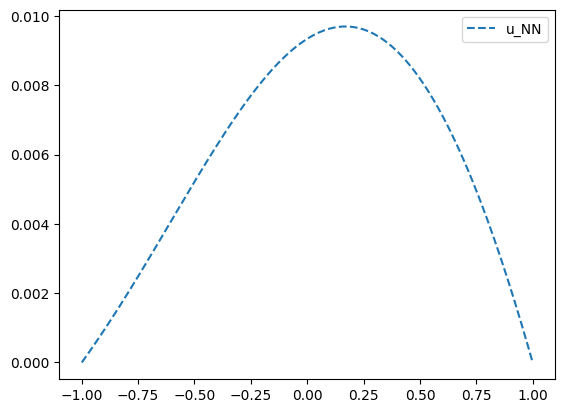

In [35]:
x = torch.linspace(-1, 1, 200).unsqueeze(1)
#plt.plot(x, ref_u(x), "-", label="u_true")
plt.plot(x, pinn_u(x).detach().numpy(), "--", label="u_NN")
plt.legend()

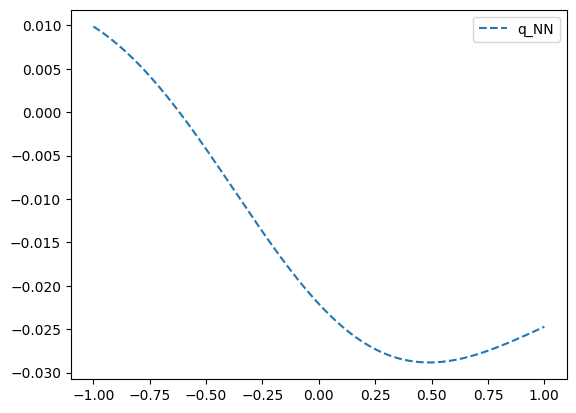

In [34]:
#plt.plot(x, ref_q(x), "-", label="q_true")
plt.plot(x, pinn_q(x).detach().numpy(), "--", label="q_NN")
plt.legend()